#### Imports

In [ ]:
import numpy as np
import gradio as gr
from zipfile import ZipFile
import os
import requests
import random
import shutil
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import layers, Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.applications.vgg19 import preprocess_input
from tensorflow.keras.utils import register_keras_serializable
from tensorflow.keras.optimizers.schedules import PiecewiseConstantDecay

### Data Download

In [ ]:
# RUN ONLY IF YOU DONT HAVE DATA SET YET

urls = [
    "http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip",
    "http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip"
]

data_dir = "../loppuprojekti/data"
os.makedirs(data_dir, exist_ok=True)

for url in urls:
    filename = os.path.join(data_dir, os.path.basename(url))
    # Download zip file
    print(f"Downloading {url}...")
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(filename, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)
    print("Download ready:", filename)
    # Exctract zip file
    print(f"Extracting {filename}...")
    with ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall(data_dir)
    print("Extracted files!")

print("Data pulling ready:", data_dir)

### Data Preparation

In [11]:
# For GPU logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

data_dir = "../loppuprojekti/data"
train = "../loppuprojekti/data/DIV2K_train_HR/"
validation = "../loppuprojekti/data/DIV2K_valid_HR/"
test = "../loppuprojekti/data/DIV2K_test_HR"

os.makedirs(test, exist_ok=True)

train_files = os.listdir(train)

num_test_files = int(len(train_files) * 0.15)

files_to_move = random.sample(train_files, num_test_files)

if not os.listdir(test):
    for file in files_to_move:
        src = os.path.join(train, file)
        dst = os.path.join(test, file)
        shutil.move(src, dst)

    print(f"Moved {len(files_to_move)} files to test directory")

else:
    print("Test files already exist")

Test files already exist


#### Data Augmentation Helper Functions

In [13]:
def flip_left_right(lowres_img, highres_img):
    """Flips Images to left and right."""

    # Outputs random values from a uniform distribution in between 0 to 1
    rn = tf.random.uniform(shape=(), maxval=1.0)

    # If rn is less than 0.5 it returns original lowres_img and highres_img
    # If rn is greater than 0.5 it returns flipped image
    return tf.cond(
        rn < 0.5,
        lambda: (lowres_img, highres_img),
        lambda: (
            tf.image.flip_left_right(lowres_img),
            tf.image.flip_left_right(highres_img),
        ),
    )


def random_rotate(lowres_img, highres_img):
    """Rotates Images by 90 degrees."""

    # Outputs random values from uniform distribution in between 0 to 4
    rn = tf.cast(tf.random.uniform(shape=(), maxval=4, dtype=tf.float32), dtype=tf.int32)

    # Here rn signifies number of times the image(s) are rotated by 90 degrees
    return tf.image.rot90(lowres_img, rn), tf.image.rot90(highres_img, rn)

#### Preprocessing helper functions

In [2]:
def prepare_model_input(img_np):
    """NumPy version: normalize and add batch dimension for inference."""
    img_np = img_np.astype(np.float32) / 255.0
    return np.expand_dims(img_np, axis=0)

def postprocess_output(sr_img):
    """Convert model output to uint8 image for display or saving."""
    sr_img = np.squeeze(sr_img, axis=0)
    return np.clip(sr_img * 255.0, 0, 255).astype(np.uint8)


def load_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3)
    return tf.image.convert_image_dtype(img, tf.float32)

def to_display_format(img):
    return np.clip(img * 255, 0, 255).astype("uint8")

#### Utility Functions

In [17]:
# Utilities
@register_keras_serializable()
class PixelShuffle(layers.Layer):
    def __init__(self, scale, **kwargs):
        super().__init__(**kwargs)
        self.scale = scale

    def call(self, inputs):
        return tf.nn.depth_to_space(inputs, block_size=self.scale)

    def get_config(self):
        config = super().get_config()
        config.update({"scale": self.scale})
        return config


@register_keras_serializable()
def PSNR(original, generated):
    return tf.image.psnr(original, generated, max_val=1.0)


def save_model(model, filepath):
    model.save(filepath)


@register_keras_serializable()
def load_model(filepath):
    return keras.models.load_model(
    filepath,
    custom_objects={
        "PixelShuffle": PixelShuffle,
        "combined_loss": combined_loss,
        "PSNR": PSNR,
        "SSIM": SSIM,
    },
)

@register_keras_serializable()
def SSIM(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val=1.0)

def combined_loss(y_true, y_pred):
    # Preprocess for VGG
    y_true_vgg = preprocess_vgg(y_true)
    y_pred_vgg = preprocess_vgg(y_pred)

    # Extract features
    f_true = vgg_model(y_true_vgg)
    f_pred = vgg_model(y_pred_vgg)

    # Perceptual loss: feature-wise MSE
    perceptual = tf.reduce_mean(tf.square(f_true - f_pred))
    pixel = tf.reduce_mean(tf.abs(y_true - y_pred))
    return 0.01 * perceptual + 1.0 * pixel

ValueError: Custom>PixelShuffle has already been registered to <class '__main__.PixelShuffle'>

#### Dataset Creation

We create the dataset by applying random cropping to each high-resolution image. This approach isn't ideal for evaluating performance on real, full-size images, but it offers a fast and memory-efficient way to train the model.

Each cropped patch is:
- Downscaled to simulate a low-resolution version (input).
- Paired with the original high-resolution patch (target).

This setup allows the model to learn super-resolution mappings using small image patches, which significantly reduces computational overhead during training.

In [14]:
AUTOTUNE = tf.data.AUTOTUNE
crop_size = 96
scale = 4

train_dir = os.path.join(data_dir, "DIV2K_train_HR")
val_dir = os.path.join(data_dir, "DIV2K_valid_HR")
test_dir = os.path.join(data_dir, "DIV2K_test_HR")

train_files = [
    os.path.join(train_dir, fname)
    for fname in os.listdir(train_dir)
    if fname.lower().endswith((".png", ".jpg", ".jpeg"))
]

val_files = [
    os.path.join(val_dir, fname)
    for fname in os.listdir(val_dir)
    if fname.lower().endswith((".png", ".jpg", ".jpeg"))
]

test_files = [
    os.path.join(test_dir, fname)
    for fname in os.listdir(test_dir)
    if fname.lower().endswith((".png", ".jpg", ".jpeg"))
]

def random_crop_and_downscale(hr_img):
    hr_patch = tf.image.random_crop(hr_img, size=[crop_size, crop_size, 3])
    hr_patch.set_shape([crop_size, crop_size, 3])
    lr_patch = tf.image.resize(
        hr_patch, [crop_size // scale, crop_size // scale], method="area"
    )
    lr_patch.set_shape([crop_size // scale, crop_size // scale, 3])
    return lr_patch, hr_patch

# Build datasets

train_ds = tf.data.Dataset.from_tensor_slices(train_files).map(
    load_image, num_parallel_calls=tf.data.AUTOTUNE
)


val_ds = tf.data.Dataset.from_tensor_slices(val_files).map(
    load_image, num_parallel_calls=tf.data.AUTOTUNE
)


test_ds = tf.data.Dataset.from_tensor_slices(test_files).map(
    load_image, num_parallel_calls=tf.data.AUTOTUNE
)


# Apply random cropping and downscaling
BATCH_SIZE = 8

train_sr = train_ds.map(random_crop_and_downscale, num_parallel_calls=tf.data.AUTOTUNE)
train_sr = train_sr.map(random_rotate, num_parallel_calls=tf.data.AUTOTUNE)
train_sr = train_sr.map(flip_left_right, num_parallel_calls=tf.data.AUTOTUNE)
train_sr = train_sr.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_sr = val_ds.map(random_crop_and_downscale, num_parallel_calls=tf.data.AUTOTUNE)
val_sr = val_sr.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_sr = test_ds.map(random_crop_and_downscale, num_parallel_calls=tf.data.AUTOTUNE)
test_sr = test_sr.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Example: print shapes

for lr, hr in train_sr.take(1):
    print("LR patch shape:", lr.shape)
    print("HR patch shape:", hr.shape)
#### Plot Example of Training Data

LR patch shape: (8, 24, 24, 3)
HR patch shape: (8, 96, 96, 3)


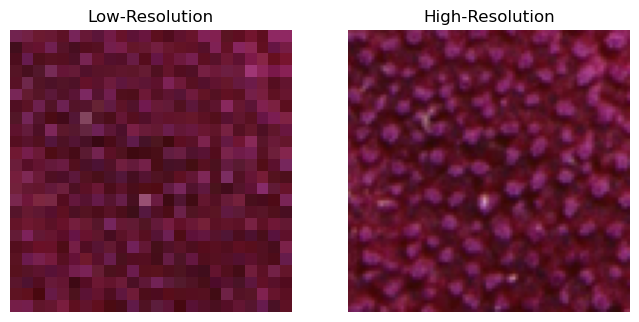

In [8]:
# Get one LR-HR pair from the dataset
for lr, hr in train_sr.take(1):
    lr_img = lr.numpy()
    hr_img = hr.numpy()

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.title("Low-Resolution")
    plt.imshow(lr_img[0])
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("High-Resolution")
    plt.imshow(hr_img[0])
    plt.axis("off")

    plt.show()

#### Construction of Model

In [9]:
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6, verbose=1
)

early_stop = EarlyStopping(
    monitor="val_loss",  # or val_calculate_psnr for PSNR
    patience=20,
    restore_best_weights=True,
)

optimizer = Adam(
    learning_rate=PiecewiseConstantDecay(
        boundaries=[5000], values=[1e-4, 5e-5]
    )
)

In [16]:
# Perceptual loss with VGG
vgg = keras.applications.VGG19(include_top=False, weights="imagenet")
vgg.trainable = False
vgg_model = Model(inputs=vgg.input, outputs=vgg.get_layer("block3_conv3").output)


def preprocess_vgg(x):
    x = tf.image.resize(x, [224, 224])
    x = preprocess_input(x * 255.0)
    return x


# Residual block layers
def ResBlock(inputs):
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(inputs)
    x = layers.Dropout(0.2)(x)
    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.Add()([inputs, x])
    return x


# Up sampling layer
def Upsampling(inputs, factor=2, **kwargs):
    x = layers.Conv2D(64 * (factor**2), 3, padding="same", **kwargs)(inputs)
    x = PixelShuffle(factor)(x)
    x = layers.Conv2D(64 * (factor**2), 3, padding="same", **kwargs)(x)
    x = PixelShuffle(factor)(x)
    return x


# Model creation function
def make_model(num_filters, num_of_residual_blocks):
    input_layer = layers.Input(shape=(None, None, 3))
    # x = layers.Rescaling(scale=1.0 / 255)(input_layer) # inputs will be preprocessed outside of the model
    x = x_new = layers.Conv2D(num_filters, 3, padding="same")(input_layer)

    for _ in range(num_of_residual_blocks):
        x_new = ResBlock(x_new)

    x_new = layers.Conv2D(num_filters, 3, padding="same")(x_new)
    x = layers.Add()([x, x_new])

    x = Upsampling(x, factor=2)
    x = layers.Conv2D(3, 3, padding="same")(x)

    output_layer = layers.Activation("sigmoid")(x)
    return Model(inputs=input_layer, outputs=output_layer)


model = make_model(num_filters=64, num_of_residual_blocks=16)

In [11]:
model.compile(optimizer=optimizer, loss="mae", metrics=[PSNR, SSIM])
model.fit(train_sr, validation_data=val_sr, epochs=50)
model.save_weights("mae.weights.h5")

Epoch 1/50
85/85 [==============================] - 27s 188ms/step - loss: 0.1527 - PSNR: 15.4655 - SSIM: 0.2327 - val_loss: 0.0847 - val_PSNR: 19.4642 - val_SSIM: 0.5281
Epoch 2/50
85/85 [==============================] - 15s 177ms/step - loss: 0.0785 - PSNR: 20.1415 - SSIM: 0.4415 - val_loss: 0.0639 - val_PSNR: 21.8215 - val_SSIM: 0.5760
Epoch 3/50
85/85 [==============================] - 16s 186ms/step - loss: 0.0630 - PSNR: 22.0151 - SSIM: 0.5315 - val_loss: 0.0580 - val_PSNR: 22.7454 - val_SSIM: 0.6015
Epoch 4/50
85/85 [==============================] - 15s 173ms/step - loss: 0.0575 - PSNR: 23.0189 - SSIM: 0.5773 - val_loss: 0.0498 - val_PSNR: 23.9866 - val_SSIM: 0.6216
Epoch 5/50
85/85 [==============================] - 16s 178ms/step - loss: 0.0504 - PSNR: 24.2016 - SSIM: 0.6127 - val_loss: 0.0480 - val_PSNR: 24.5356 - val_SSIM: 0.6347
Epoch 6/50
85/85 [==============================] - 15s 175ms/step - loss: 0.0493 - PSNR: 24.4406 - SSIM: 0.6231 - val_loss: 0.0474 - val_PSNR: 2

In [12]:
model.load_weights('mae.weights.h5')
model.compile(optimizer=optimizer, loss=combined_loss, metrics=[PSNR, SSIM])
history = model.fit(train_sr, validation_data=val_sr, epochs=50, callbacks=[early_stop])
model.save('super_resolution_model.keras')

Epoch 1/50
85/85 [==============================] - 31s 236ms/step - loss: 416.3349 - PSNR: 24.2613 - SSIM: 0.7083 - val_loss: 388.1254 - val_PSNR: 26.2125 - val_SSIM: 0.6928
Epoch 2/50
85/85 [==============================] - 19s 220ms/step - loss: 386.5992 - PSNR: 26.4570 - SSIM: 0.7318 - val_loss: 408.1391 - val_PSNR: 26.0997 - val_SSIM: 0.6932
Epoch 3/50
85/85 [==============================] - 20s 227ms/step - loss: 373.7112 - PSNR: 27.2937 - SSIM: 0.7382 - val_loss: 349.3111 - val_PSNR: 26.5607 - val_SSIM: 0.7310
Epoch 4/50
85/85 [==============================] - 19s 224ms/step - loss: 360.9423 - PSNR: 27.5790 - SSIM: 0.7371 - val_loss: 366.1183 - val_PSNR: 27.3223 - val_SSIM: 0.7360
Epoch 5/50
85/85 [==============================] - 19s 222ms/step - loss: 376.8801 - PSNR: 27.4977 - SSIM: 0.7385 - val_loss: 351.8800 - val_PSNR: 27.1838 - val_SSIM: 0.7349
Epoch 6/50
85/85 [==============================] - 20s 233ms/step - loss: 355.4792 - PSNR: 27.6535 - SSIM: 0.7470 - val_loss

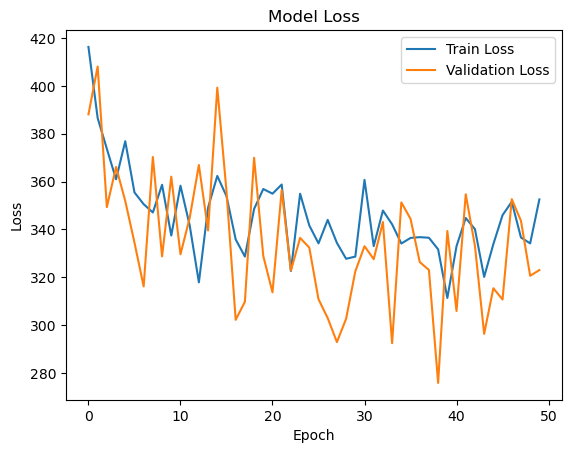

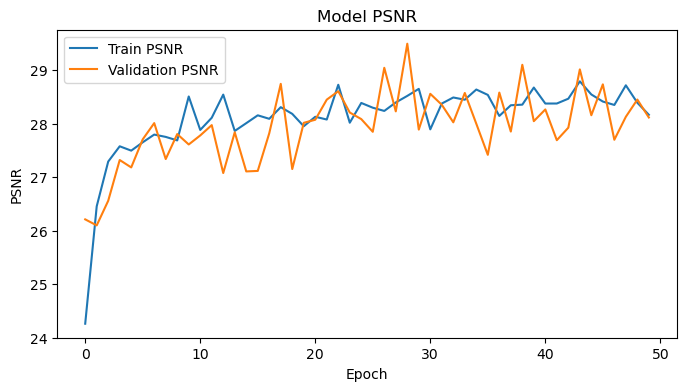

In [16]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()


# Bigger the PSNR value is, more prediction and original high res images are same
plt.figure(figsize=(8, 4))
plt.plot(history.history['PSNR'], label='Train PSNR')
plt.plot(history.history['val_PSNR'], label='Validation PSNR')
plt.title('Model PSNR')
plt.ylabel('PSNR')
plt.xlabel('Epoch')
plt.legend()

plt.show()

#### Test

This block demonstrates how the model performs super-resolution on a degraded full-size image.

To simulate a low-resolution image:
- The original high-resolution image is downscaled using area interpolation (which preserves structural detail).
- It is then upscaled back to the original size using nearest-neighbor interpolation, introducing visible blockiness and pixelation.
- This artificially degraded image is fed into the model to generate a super-resolved output.

1/1 [==============================] - 0s 33ms/step


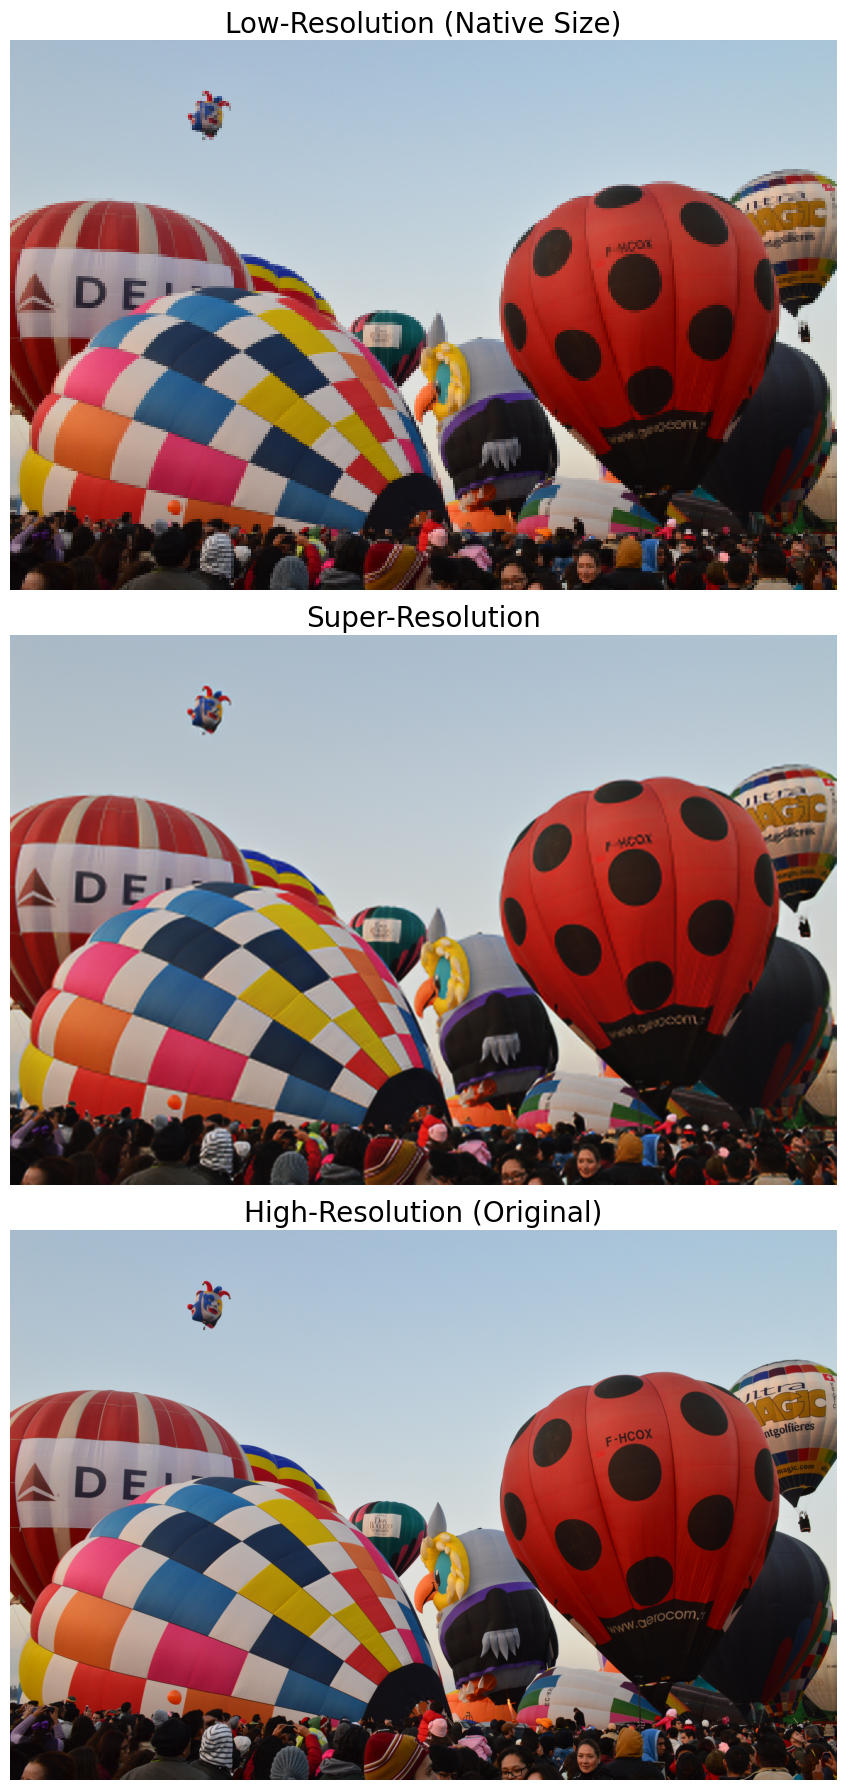

In [25]:
N = 7
for i, hr_img in enumerate(test_ds):
    if i == N:
        hr_img = hr_img.numpy()
        break

# Convert image to bad quality
scale = 6
h, w = hr_img.shape[0], hr_img.shape[1]
lr_img = tf.image.resize(hr_img, [h // scale, w // scale], method="area")
lr_img_blocky = tf.image.resize(lr_img, [h, w], method="nearest").numpy()

# Predict super-resolution image
lr_input = np.expand_dims(lr_img, axis=0)
sr_img = model.predict(lr_input)

# Post-process output image
sr_img_disp = postprocess_output(sr_img)

# Convert HR and LR images for display
hr_img_disp = to_display_format(hr_img)
lr_img_disp = to_display_format(lr_img_blocky)

# Plot the images
plt.figure(figsize=(18, 18))

plt.subplot(3, 1, 1)
plt.title("Low-Resolution (Native Size)", fontsize=20)
plt.imshow(lr_img_disp, interpolation='nearest')
plt.axis("off")

plt.subplot(3, 1, 2)
plt.title("Super-Resolution", fontsize=20)
plt.imshow(sr_img_disp)
plt.axis("off")

plt.subplot(3, 1, 3)
plt.title("High-Resolution (Original)", fontsize=20)
plt.imshow(hr_img_disp)
plt.axis("off")

plt.tight_layout()
plt.show()


#### Model demo

**Prerequisites**

Before running the demo, make sure to run the following cells first:
- `Imports`
- `Utility functions`
- `Preprocessing helper functions`

---

**Setup and Configuration:**


The model was trained, saved and loaded using a GPU environment with the following setup:

  - **Python**: 3.10.16
  - **Keras**: 2.10.0
  - **TensorFlow**: 2.10.1
  - **NumPy**: 1.26.4

Attempts to load the model in a different interpreter (with newer versions of Python, TensorFlow, or Keras) failed — likely due to version incompatibilities between these libraries. Additionally, newer versions of NumPy caused import errors in this setup.

**Note**: If you're unable to run this cell, ensure your environment matches the configuration above to avoid compatibility issues when loading the model.

In [6]:
saved_model = load_model("super_resolution_model.keras")

def superRes(input_img):

    img_array = prepare_model_input(input_img)
    sr_img = saved_model.predict(img_array)
    return postprocess_output(sr_img)

demo = gr.Interface(fn=superRes, inputs=gr.Image(type="numpy"), outputs="image")

if __name__ == "__main__":
    demo.launch()


* Running on local URL:  http://127.0.0.1:7861
* To create a public link, set `share=True` in `launch()`.
